# Project B: Regression for Boundary Value Problems in Solid Mechanics

## Task B04

####   Muhammad Sajid Ali - 391708
####   Kamil Karwacki - 355051
####   Praveen Mishra - 389850

###### Input features: Ui_boundary, Xi

###### Targets: Ui, Si

##### Reference architecture: Time-distributed Dense

###### Our architecture: ConvNet and RecNet

## Imports

In [1]:
!pip install sortedcontainers pandas

In [2]:
%matplotlib notebook

In [3]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib
import metrics
import masking as msk


from matplotlib import pyplot as plt
from helpers import DataReader, plot_sample

In [4]:
# Choose 'svg' to be able to modify the vectorized file e.g. in inkscape for your presentation (remove unnecessary boxes)
matplotlib.rcParams['savefig.format'] = 'png'

## Data

In [5]:
tfrecord_dir = os.path.join('..', 'data','tfrecord')
tfrecord_files = glob.glob(os.path.join(tfrecord_dir, '*'))
np.random.shuffle(tfrecord_files)


In [6]:
data_format = 'NSXYF'     # Axes in data: Samples (N), Sequence (S), X-Axis (X), Y-Axis (Y), Features (F)
data_shape = [None, 100, 9, 9, 21] 

In [7]:
idx = {'Xi_boundary': [0, 1],
       'Ui': [8, 9],
       'Fi': [16, 17],
       'boundary': [4],
       'Xi': [6, 7],
       'Ui_boundary': [2, 3],
       'body': [5],
       'Si': [10, 11, 12, 13, 14, 15]}
input_features = idx['Ui_boundary'] + idx['Xi']
output_features = idx['Ui'] + idx['Si']

In [8]:
batch_size = 32 #len(tfrecord_files)
data_reader = DataReader(data_shape, data_format,  batch_size=batch_size, src_type='file',
                         slice_tensors=False, buffer_size=1000,
                         input_features=input_features, output_features=output_features,
                         sample_dtype=tf.float64, cast_dtype=tf.float32)

## Split data into datasets

The data is split into 60% training - 20% validation - 20% testing.

In [9]:
data_size = len(tfrecord_files)
percent_valid  = 1
percent_test   = 0.8
percent_train  = 0.6

train_data =  tfrecord_files[:int(percent_train*data_size)]
valid_data =  tfrecord_files[int(percent_train*data_size) : int(percent_test*data_size)]
test_data  =  tfrecord_files[int(percent_test*data_size) : int(percent_valid*data_size)]

print("Overall {} files".format(data_size))
print("Training with {} files".format(len(train_data)))
print("Testing with {} files".format(len(test_data)))
print("validating with {} files".format(len(valid_data)))
         

Overall 352 files
Training with 211 files
Testing with 71 files
validating with 70 files


## Read data

In [17]:
train_dataset = data_reader.generate_batch_dataset(train_data, batch_size)
valid_dataset = data_reader.generate_batch_dataset(valid_data, batch_size)
test_dataset = data_reader.generate_test_dataset(test_data)

`extract_image` is a function written to plot the data. It taken in a tensor and the feature number as input and plots the feature on a XY plane.

In [18]:
def extract_image(tensor3D, feature=0):
    data_for_plot = np.zeros((9,9))

    for i in range(len(tensor3D)):
        for j in range(len(tensor3D[0])):
            data_for_plot[i][j] = tensor3D[i][j][feature]
            
    return data_for_plot

Converting to make it suitable for plotting

In [24]:
Y = list(test_dataset)
Y = tf.concat([Y[i][1] for i in range(len(Y))], 0)

<IPython.core.display.Javascript object>


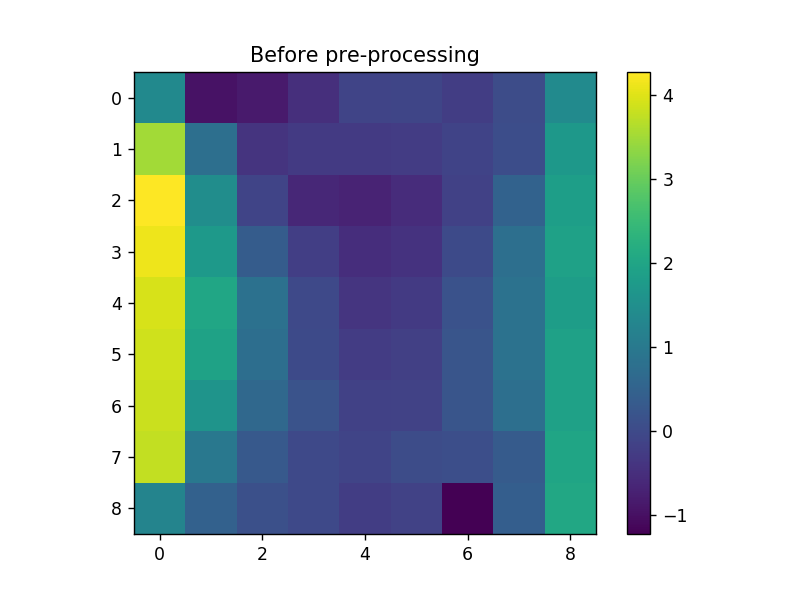

Text(0.5, 1.0, 'Before pre-processing')

In [25]:
plt.imshow(extract_image(Y[5][0],2))
plt.colorbar()
plt.title('Before pre-processing')

## Data preprocessing

The function `preprocess` takes in a tensor batch and then finds the absolute value and maasks the values to zeros and ones. The mean and standard deviation is calculated for the values masked with ones. Finally the data is normalized as follows.
 $$x_{norm} = \frac{x-mean}{SD}$$

In [21]:
def preprocess(x):

    # calculate a mask to not take 0 values into concideration
    x_abs = tf.abs(x)
    full_mask = tf.cast(tf.sign(x_abs), tf.bool)

    # calculate mean and var over all features
    mean, var = tf.nn.weighted_moments(x, frequency_weights=tf.cast(full_mask, tf.float64), axes=(0, 1, 2, 3))
    std = tf.sqrt(var)
  
    # only scale non zero values
    x = tf.where(full_mask, (x - mean) / std, x)
    
    return x


def preprocess_fun(*batch):
    return (preprocess(batch[0]), preprocess(batch[1]))


processed_train_dataset = train_dataset.map(preprocess_fun)
processed_test_dataset  = test_dataset.map(preprocess_fun)
processed_valid_dataset  = valid_dataset.map(preprocess_fun)


Converting to make it suitable for plotting

In [26]:
Y = list(processed_test_dataset)
Y = tf.concat([Y[i][1] for i in range(len(Y))], 0)

<IPython.core.display.Javascript object>


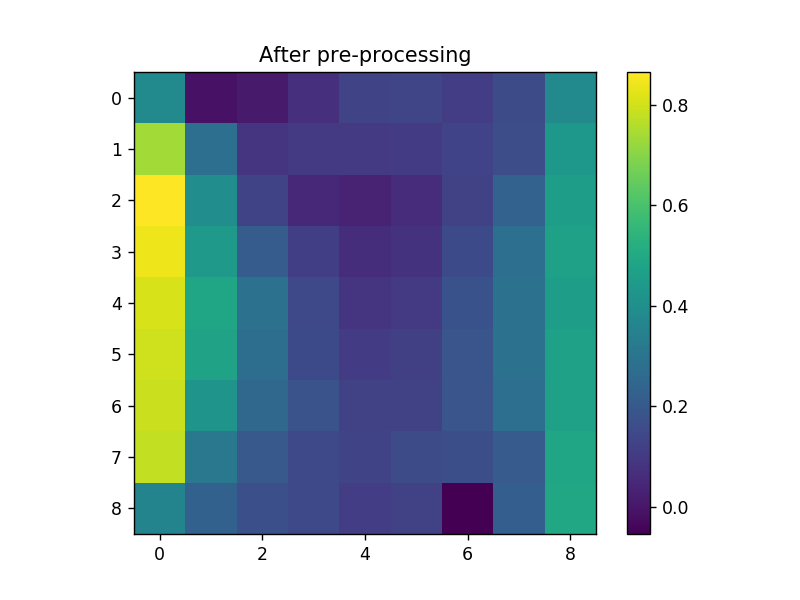

Text(0.5, 1.0, 'After pre-processing')

In [27]:
plt.imshow(extract_image(Y[5][0],2))
plt.colorbar()
plt.title('After pre-processing')

## Reference neural network architecture

The function `create_ref_model` creates our refrence NN architecture with $\texttt{num_units}$ as inputs. The NN consists mainly of a masking layer followed by masked time distributed dense layers. 

The input shape is (32,100,9,9,4) and the output shape is (32,100,9,9,8).

In [13]:
def create_ref_model(num_units):
    input_shape = list(data_shape[1:-1]) + [len(input_features)]
    inputs = tf.keras.Input(input_shape, batch_size=batch_size)
    x = inputs
  
    masklayer = msk.SequenceMasking(mask_value=0.0)
    x = masklayer(x)

    # some hidden layers with rising and then fallign number of nodes
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(num_units, activation="linear"))
    x = layer(x)
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(4*num_units, activation="relu"))
    x = layer(x)
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(8*num_units, activation="relu"))
    x = layer(x)
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(4*num_units, activation="relu"))
    x = layer(x)
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(num_units, activation="relu"))
    x = layer(x)
    
    # output layer
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(len(output_features), activation="linear"))
    y_ = layer(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=y_)
    print(model.summary())
    return model

In [14]:
# hyper parameters
num_units = 20

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Create model
ref_model = create_ref_model(num_units)

# Compile
ref_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 100, 9, 9, 4)]      0         
_________________________________________________________________
sequence_masking (SequenceMa (32, 100, 9, 9, 4)        0         
_________________________________________________________________
masked_time_distributed (Mas (32, 100, 9, 9, 20)       100       
_________________________________________________________________
masked_time_distributed_1 (M (32, 100, 9, 9, 80)       1680      
_________________________________________________________________
masked_time_distributed_2 (M (32, 100, 9, 9, 160)      12960     
_________________________________________________________________
masked_time_distributed_3 (M (32, 100, 9, 9, 80)       12880     
_________________________________________________________________
masked_time_distributed_4 (M (32, 100, 9, 9, 20)       1620  

In [15]:
# Training
history_ref = ref_model.fit(processed_train_dataset, steps_per_epoch=100, epochs=10,callbacks=[callback],
          validation_steps=100, validation_data=processed_valid_dataset)

Train for 100 steps, validate for 100 steps
Epoch 1/10
100/100 [==============================] - 147s 1s/step - loss: 0.1434 - mae: 0.4064 - val_loss: 0.1260 - val_mae: 0.3795
Epoch 2/10
100/100 [==============================] - 126s 1s/step - loss: 0.1231 - mae: 0.3599 - val_loss: 0.1228 - val_mae: 0.3769
Epoch 3/10
100/100 [==============================] - 125s 1s/step - loss: 0.1211 - mae: 0.3537 - val_loss: 0.1208 - val_mae: 0.3668
Epoch 4/10
100/100 [==============================] - 127s 1s/step - loss: 0.1200 - mae: 0.3524 - val_loss: 0.1205 - val_mae: 0.3660
Epoch 5/10
100/100 [==============================] - 123s 1s/step - loss: 0.1189 - mae: 0.3510 - val_loss: 0.1190 - val_mae: 0.3662
Epoch 6/10
100/100 [==============================] - 122s 1s/step - loss: 0.1184 - mae: 0.3503 - val_loss: 0.1202 - val_mae: 0.3757
Epoch 7/10
100/100 [==============================] - 123s 1s/step - loss: 0.1177 - mae: 0.3472 - val_loss: 0.1186 - val_mae: 0.3576
Epoch 8/10
100/100 [=====

In [16]:
# evaluation
loss_ref = ref_model.evaluate(processed_test_dataset)
print('Loss =',loss_ref[0])
print('mae =',loss_ref[1])

3/3 [==============================] - 3s 1s/step - loss: 0.1166 - mae: 0.3446
Loss = 0.11662860463062923
mae = 0.34464014


# Own neural network architecture

The function `create_our_model` creates our own NN architecture with $\texttt{num_units}$ as inputs. The NN consists mainly of a masking layer followed by a convolutional layer, followed by a LSTm layer and finally a maksed time distributed dense layer and a reshape to give the desired output . 

The input shape is (32,100,9,9,4) and the output shape is (32,100,9,9,8).

In [29]:
def create_our_model(num_units):
    input_shape = list(data_shape[1:-1]) + [len(input_features)]
    inputs = tf.keras.Input(input_shape,batch_size=batch_size)

    x = inputs
    
    masklayer = msk.SequenceMasking(mask_value=0.0)
    x = masklayer(x)
    
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Conv2D(num_units, (3,3),input_shape=input_shape, padding="same", activation="relu"))
    x = layer(x)
    #pooling = msk.MaskedTimeDistributed(tf.keras.layers.MaxPooling2D((3,3),padding="same"))
    #x = pooling(x)
    
    y_ = tf.keras.backend.reshape(x, [-1, 100, 9*9*num_units])
    
    # Recursive    
    recursive = tf.keras.layers.LSTM(num_units, return_sequences=True,activation='relu')
    y_ = recursive(y_)
    
    
    # output layer
    layer = msk.MaskedTimeDistributed(tf.keras.layers.Dense(9*9*len(output_features), activation="linear"))
    y_ = layer(y_)
    
    y_ = tf.keras.backend.reshape(y_, [-1,100,9,9,len(output_features)])
    
    model = tf.keras.models.Model(inputs=inputs, outputs=y_) 
    print(model.summary())
    return model

In [30]:
# hyper parameters
num_units = 20

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Create model
our_model = create_our_model(num_units)
our_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 100, 9, 9, 4)]      0         
_________________________________________________________________
sequence_masking_3 (Sequence (32, 100, 9, 9, 4)        0         
_________________________________________________________________
masked_time_distributed_10 ( (32, 100, 9, 9, 20)       740       
_________________________________________________________________
tf_op_layer_Reshape_4 (Tenso [(32, 100, 1620)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (32, 100, 20)             131280    
_________________________________________________________________
masked_time_distributed_11 ( (32, 100, 648)            13608     
_________________________________________________________________
tf_op_layer_Reshape_5 (Tenso [(32, 100, 9, 9, 8)]      0   

In [31]:
# Training
history_our = our_model.fit(processed_train_dataset, steps_per_epoch=100, epochs=10,callbacks=[callback],
          validation_steps=100, validation_data=processed_valid_dataset)

Train for 100 steps, validate for 100 steps
Epoch 1/10
100/100 [==============================] - 57s 569ms/step - loss: 0.1250 - mae: 0.1058 - val_loss: 0.0495 - val_mae: 0.0788
Epoch 2/10
100/100 [==============================] - 57s 566ms/step - loss: 0.0356 - mae: 0.0595 - val_loss: 0.0280 - val_mae: 0.0523
Epoch 3/10
100/100 [==============================] - 57s 573ms/step - loss: 0.0238 - mae: 0.0442 - val_loss: 0.0276 - val_mae: 0.0528
Epoch 4/10
100/100 [==============================] - 58s 575ms/step - loss: 0.0216 - mae: 0.0416 - val_loss: 0.0285 - val_mae: 0.0516
Epoch 5/10
100/100 [==============================] - 58s 583ms/step - loss: 0.0203 - mae: 0.0397 - val_loss: 0.0232 - val_mae: 0.0435
Epoch 6/10
100/100 [==============================] - 58s 580ms/step - loss: 0.0188 - mae: 0.0379 - val_loss: 0.0274 - val_mae: 0.0474
Epoch 7/10
100/100 [==============================] - 59s 589ms/step - loss: 0.0177 - mae: 0.0368 - val_loss: 0.0227 - val_mae: 0.0447
Epoch 8/10


In [32]:
# evaluation
loss_our = our_model.evaluate(processed_test_dataset)
print('Loss =',loss_our[0])
print('mae =',loss_our[1])

3/3 [==============================] - 0s 149ms/step - loss: 0.0290 - mae: 0.0418
Loss = 0.02896507332722346
mae = 0.04175983


# Comparison Plots

In [33]:
# Get training and test loss histories
ref_training_loss = history_ref.history['loss']
ref_training_mae = history_ref.history['mae']
ref_val_loss = history_ref.history['val_loss']
ref_val_mae = history_ref.history['val_mae']
our_training_loss = history_our.history['loss']
our_training_mae = history_our.history['mae']
our_val_loss = history_our.history['val_loss']
our_val_mae = history_our.history['val_mae']

<IPython.core.display.Javascript object>


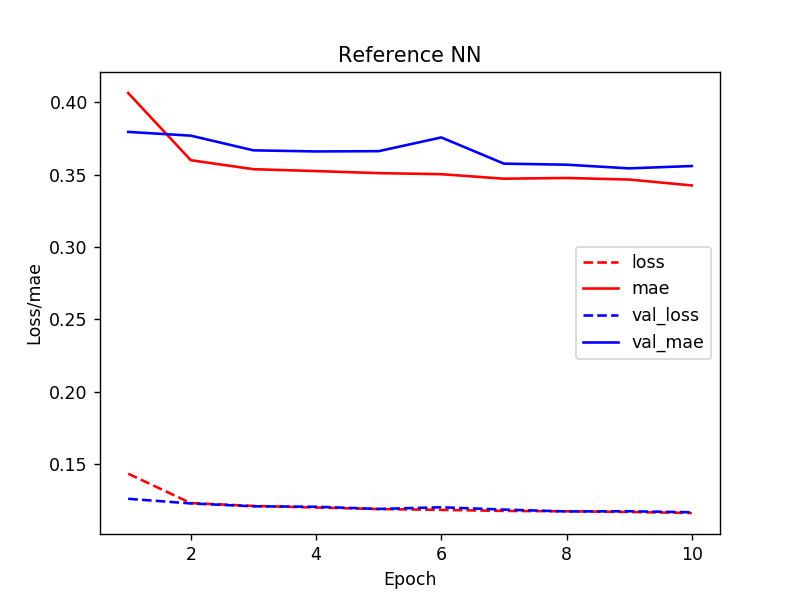

In [34]:
# Refrence NN
epoch_count = range(1, len(ref_training_loss) + 1)
plt.plot(epoch_count, ref_training_loss, 'r--')
plt.plot(epoch_count, ref_training_mae, 'r-')
plt.plot(epoch_count, ref_val_loss, 'b--')
plt.plot(epoch_count, ref_val_mae, 'b-')
plt.legend(['loss', 'mae','val_loss', 'val_mae'])
plt.xlabel('Epoch')
plt.ylabel('Loss/mae')
plt.title('Reference NN')
plt.show();

<IPython.core.display.Javascript object>


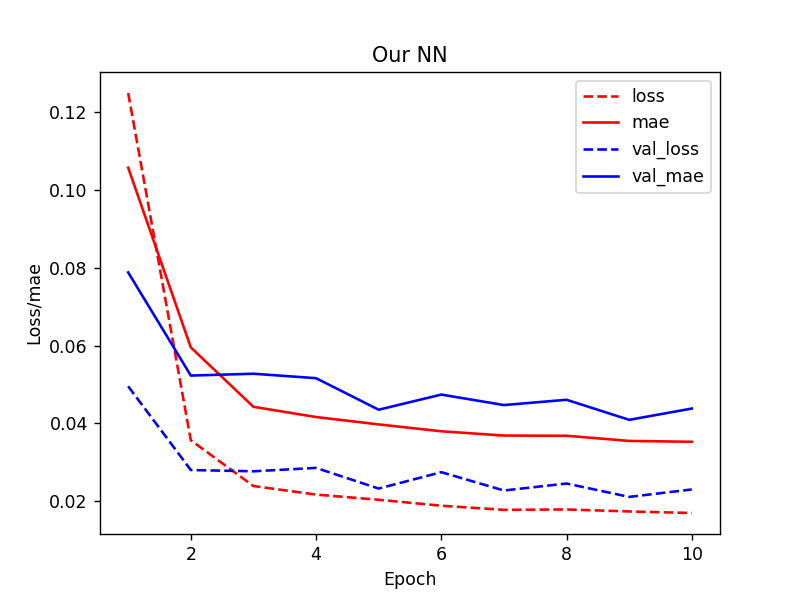

In [35]:
# Our NN
epoch_count = range(1, len(our_training_loss) + 1)
plt.plot(epoch_count, our_training_loss, 'r--')
plt.plot(epoch_count, our_training_mae, 'r-')
plt.plot(epoch_count, our_val_loss, 'b--')
plt.plot(epoch_count, our_val_mae, 'b-')
plt.legend(['loss', 'mae','val_loss', 'val_mae'])
plt.xlabel('Epoch')
plt.ylabel('Loss/mae')
plt.title('Our NN')
plt.show();

# SMAPE

In [29]:
# Predicted output
Y_predicted_ref = ref_model.predict(processed_test_dataset)
Y_predicted_our = our_model.predict(processed_test_dataset)

In [40]:
# Real output
Y_real = list(processed_test_dataset)
Y_real = tf.concat([Y_real[i][1] for i in range(len(Y_real))], 0) #Y_real[0][1]


In [41]:
smape_ref = metrics.symmetric_mean_absolute_percentage_error(
    Y_real, Y_predicted_ref, reduction_axes=None, norm_axes=(0,1,2,3,4), norm_mode='range')
smape_our = metrics.symmetric_mean_absolute_percentage_error(
    Y_real, Y_predicted_our, reduction_axes=None, norm_axes=(0,1,2,3,4), norm_mode='range')
print('Reference NN smape =',smape_ref)
print('Our NN smape =',smape_our)

Reference NN smape = 0.5188846960663795
Our NN smape = 0.2181044314056635


# Visualization

The following shows plots for Si for real, predicted by reference NN and our NN respectively.

<IPython.core.display.Javascript object>


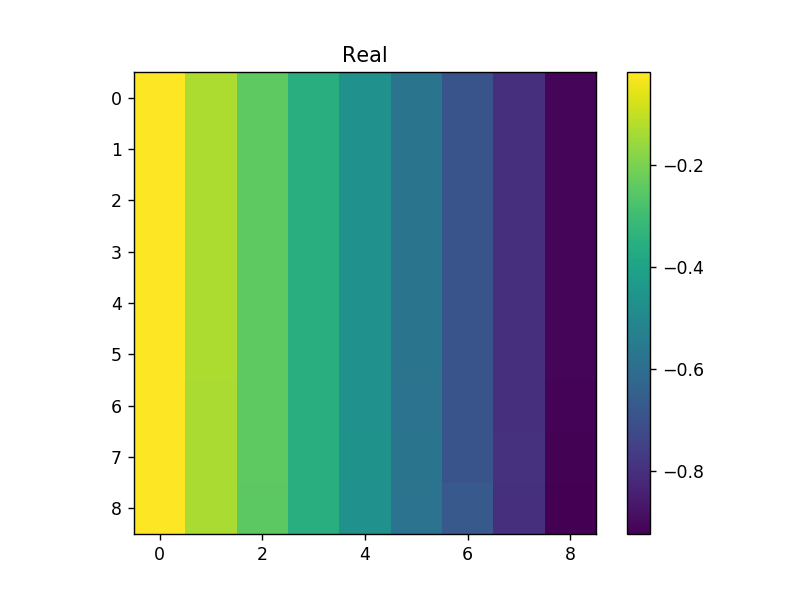

Text(0.5, 1.0, 'Real')

In [56]:
plt.imshow(extract_image(Y_real[5][0],2))
plt.colorbar()
plt.title('Real')


<IPython.core.display.Javascript object>


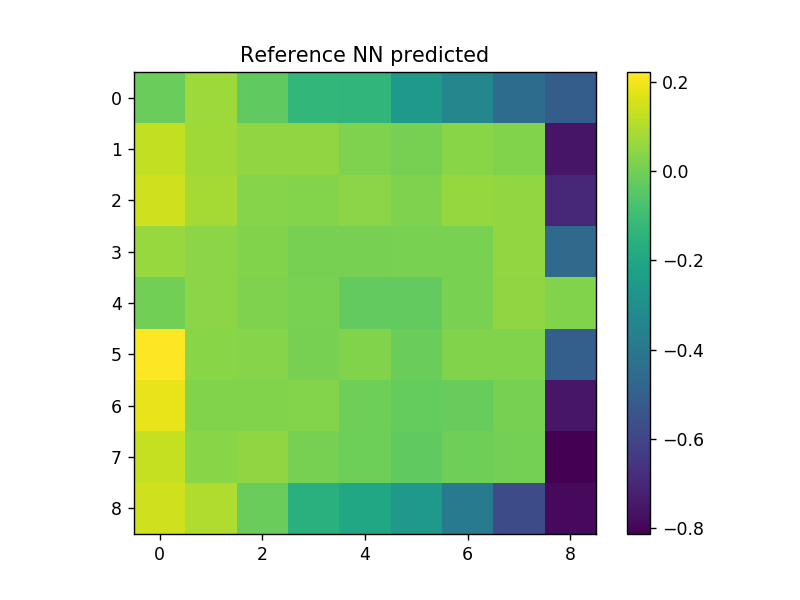

Text(0.5, 1.0, 'Reference NN predicted')

In [57]:
plt.imshow(extract_image(Y_predicted_ref[5][0],2))
plt.colorbar()
plt.title('Reference NN predicted')

<IPython.core.display.Javascript object>


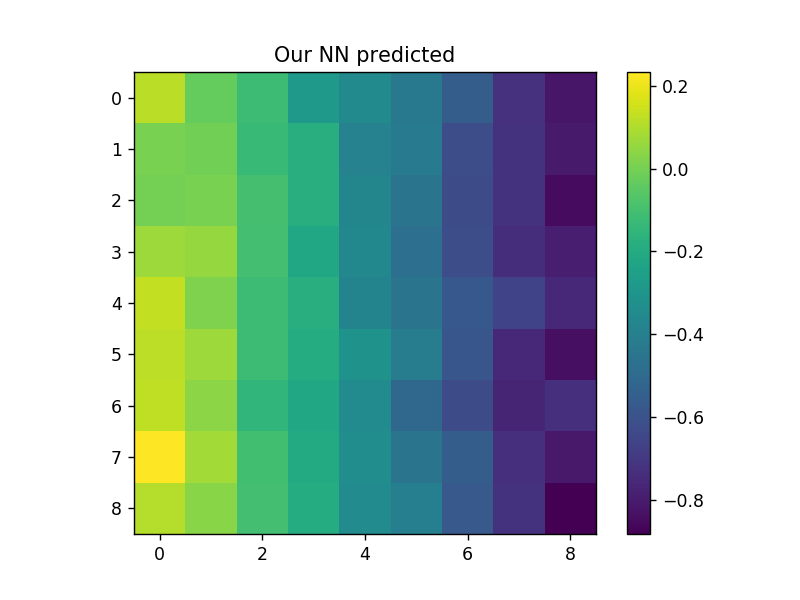

Text(0.5, 1.0, 'Our NN predicted')

In [58]:
plt.imshow(extract_image(Y_predicted_our[5][0],2))
plt.colorbar()
plt.title('Our NN predicted')

Following are just plots to view all features at once with the help of `joint_plot` function.

In [59]:
def joint_plot(Y):
    
    plt.figure(figsize=(10,10))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(extract_image(Y[5][0],i))
        plt.colorbar(fraction=0.05)
    plt.show()

<IPython.core.display.Javascript object>


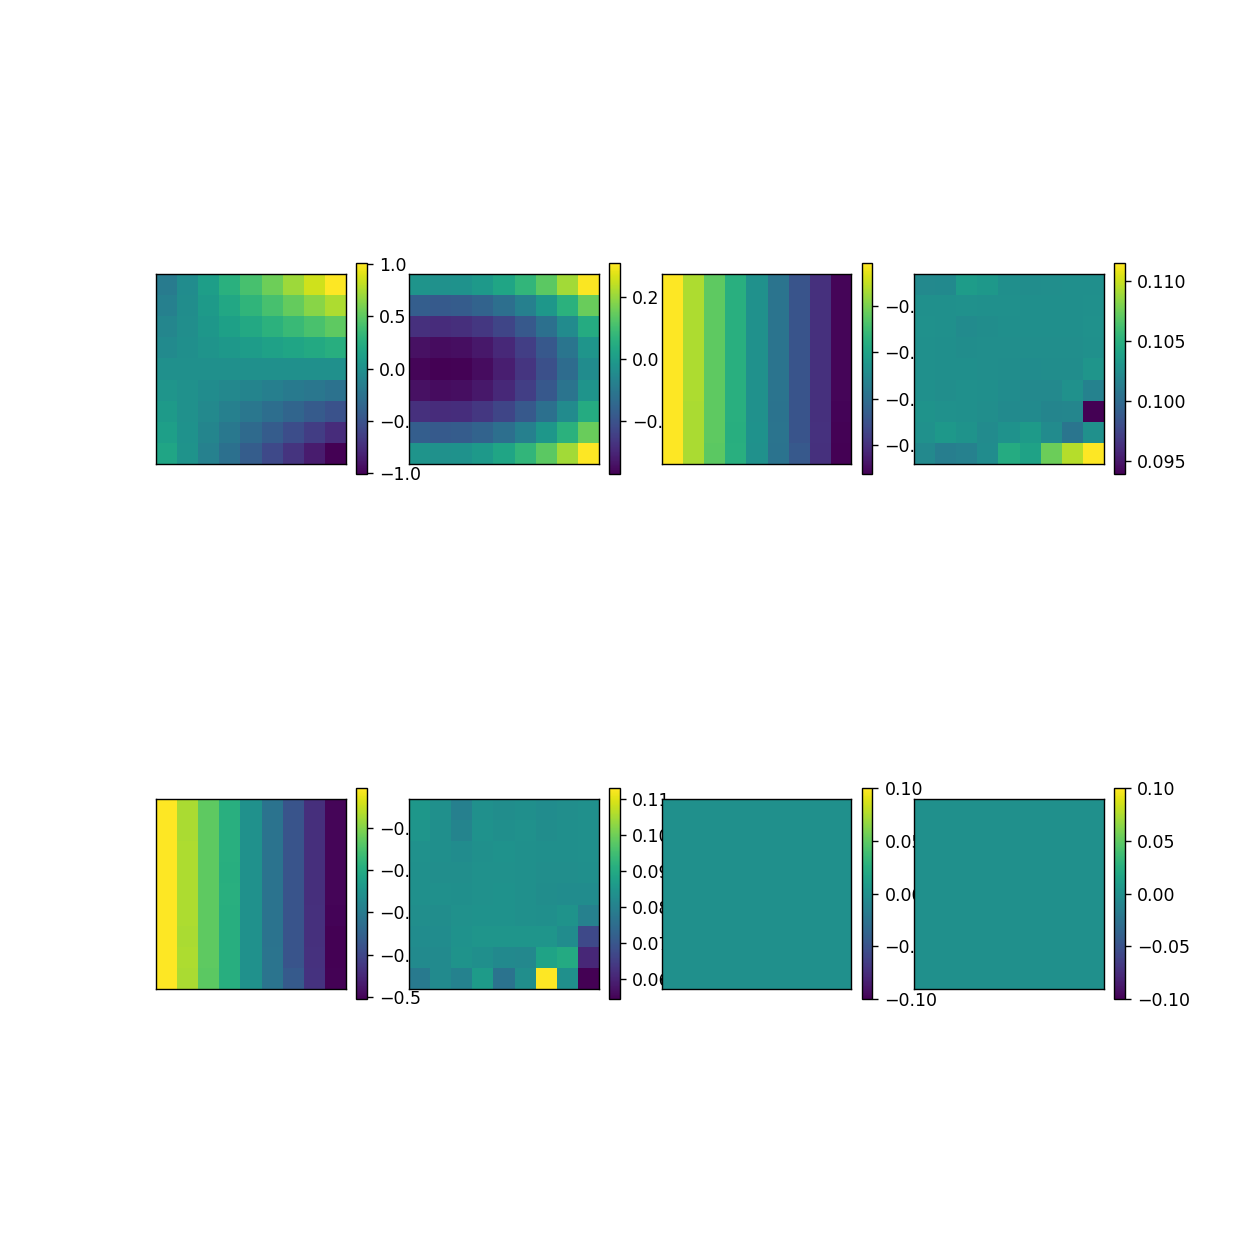

In [60]:
joint_plot(Y_real)

<IPython.core.display.Javascript object>


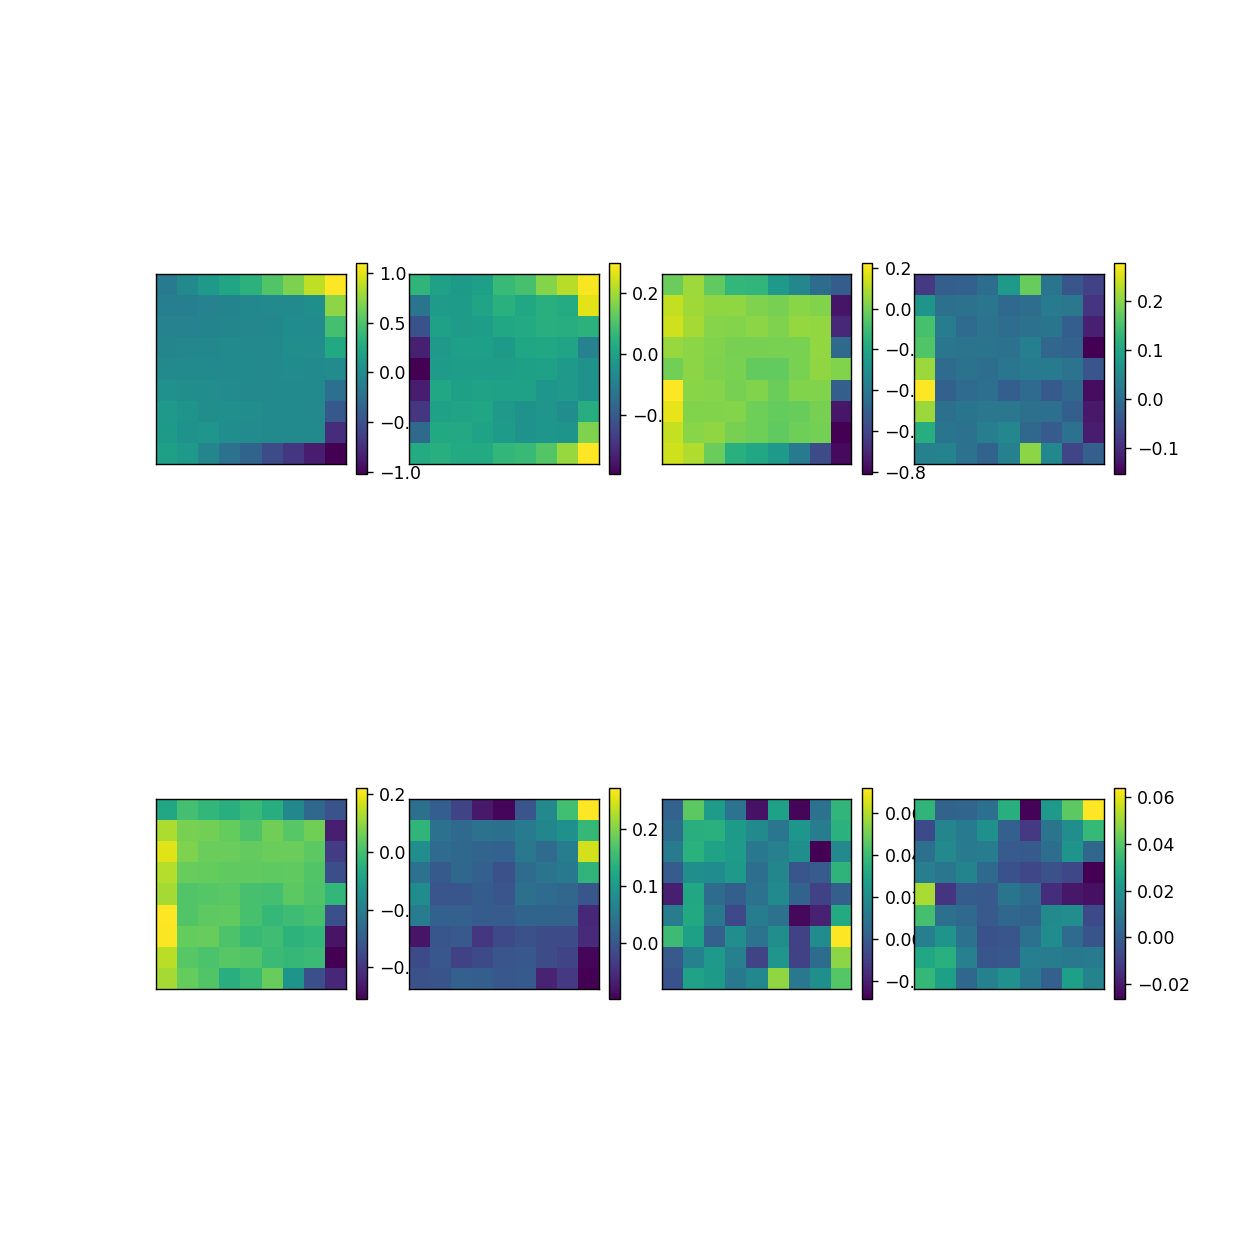

In [61]:
joint_plot(Y_predicted_ref)

<IPython.core.display.Javascript object>


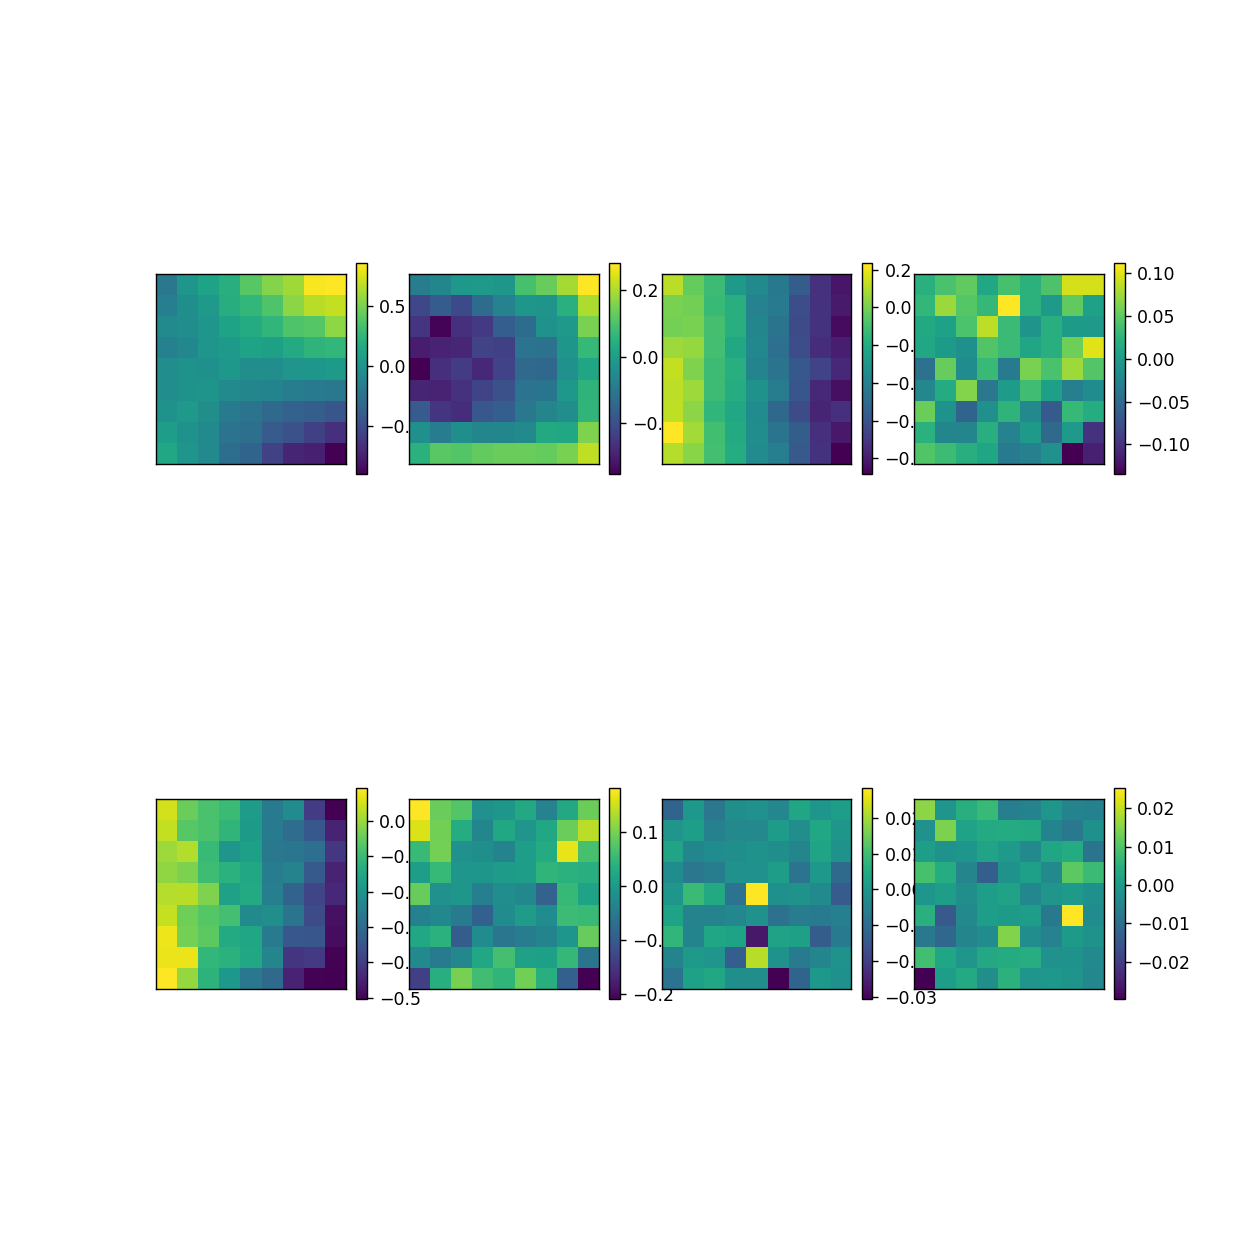

In [62]:
joint_plot(Y_predicted_our)